### Evaluation & Metrics

This notebook evaluates the performance of two main tasks in our NLP pipeline:
1. **Resume Classification** (Supervised Learning)
2. **Job Matching** (Unsupervised Similarity)

We assess classification accuracy, precision, recall, F1-score, and cosine similarity for matching relevance.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#### **Resume Classification – Supervised Learning**

- We aim to classify resumes into predefined categories such as HR, Engineering, IT, etc. using a machine learning pipeline with TF-IDF and LinearSVC.

- The goal is to evaluate how well our classifier distinguishes between job domains based on resume content.

##### **Data Prep & TF-IDF:**

In [ ]:
#Loading the data
resumes_df = pd.read_csv("/content/drive/MyDrive/IE7500 Project - Cleaned Data/Cleaned_Resume.csv")
X = resumes_df["Cleaned_Resume"].fillna("")
y = resumes_df["Category"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

##### **Model Training & Evaluation:**

- We train a Linear Support Vector Classifier (LinearSVC) using the TF-IDF features. We then evaluate the model using standard classification metrics.

##### **Model Fit & Metrics:**

In [ ]:
clf = LinearSVC(C=1.0)
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)

In [ ]:
print("Resume Classification Results")
print("Accuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Resume Classification Results
Accuracy: 71.63 %

Classification Report:
                        precision    recall  f1-score   support

            ACCOUNTANT       0.87      0.90      0.88        29
              ADVOCATE       0.61      0.73      0.67        30
           AGRICULTURE       0.25      0.12      0.17         8
               APPAREL       0.69      0.55      0.61        20
                  ARTS       0.55      0.33      0.41        18
            AUTOMOBILE       0.67      0.33      0.44         6
              AVIATION       0.75      0.86      0.80        21
               BANKING       0.80      0.70      0.74        23
                   BPO       0.50      0.50      0.50         2
  BUSINESS-DEVELOPMENT       0.96      0.81      0.88        27
                  CHEF       0.89      0.71      0.79        24
          CONSTRUCTION       0.88      0.82      0.85        34
            CONSULTANT       0.57      0.40      0.47        20
              DESIGNER       0.

##### **Confusion Matrix:**

- The confusion matrix gives a class-by-class breakdown of true vs predicted labels. This helps visualize which resume categories are being confused the most.

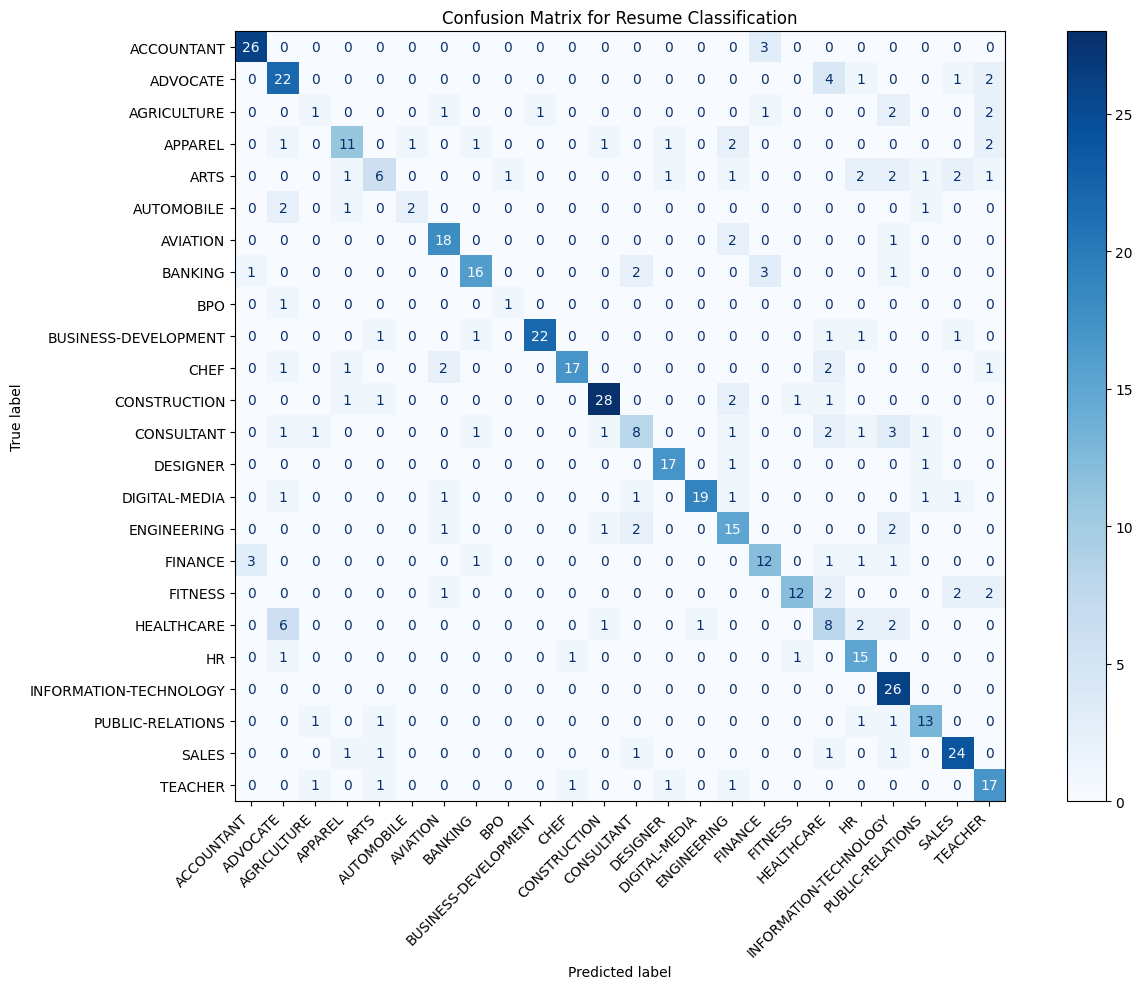

In [ ]:
labels = sorted(list(set(y_test)))

cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(14, 10))  # Wider figure
disp.plot(ax=ax, cmap="Blues", colorbar=True)

# Improve readability
plt.xticks(rotation=45, ha='right')  # Rotate and align x-axis labels
plt.yticks(rotation=0)
plt.title("Confusion Matrix for Resume Classification")
plt.tight_layout()
plt.grid(False)
plt.show()

#### **Job Matching – Evaluation & Metrics (Unsupervised Cosine Similarity)**

- This task matches resumes to job postings based on semantic similarity. We use the SentenceTransformer model all-MiniLM-L6-v2 to compute semantic embeddings of resumes and job postings. Cosine similarity is used to match resumes to the modst relevant job postings

- The output is the **mean Top-5 similarity score**, representing how well each resume matches to any job.

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
resumes_df = pd.read_csv("/content/drive/MyDrive/IE7500 Project - Cleaned Data/Cleaned_Resume.csv")            # Replace with actual path
jobs_df = pd.read_csv("/content/drive/MyDrive/IE7500 Project - Cleaned Data/postings_enriched.csv")            # Replace with actual path
job_skills_df = pd.read_csv("/content/drive/MyDrive/IE7500 Project - Cleaned Data/job_skills_cleaned.csv")
skills_df = pd.read_csv("/content/drive/MyDrive/IE7500 Project - Cleaned Data/skills_cleaned.csv")

In [ ]:
#Data Merging - merging csvs to include Title + Description + Skill Names
job_skills_df = job_skills_df.merge(
    skills_df,
    on="skill_abr",
    how="left"
)

# Aggregate skills for each job
skills_per_job = (
    job_skills_df
    .groupby("job_id")["skill_name"]
    .apply(lambda x: " ".join(x.dropna()))
    .reset_index()
)

# Merge into job postings
jobs_df = jobs_df.merge(skills_per_job, on="job_id", how="left")

# Create final job_text field
jobs_df["job_text"] = (
    jobs_df["Cleaned_Title"].fillna("") + " " +
    jobs_df["Cleaned_Description"].fillna("") + " " +
    jobs_df["skill_name"].fillna("")
)

jobs_df[["job_id", "job_text"]].head()

,job_id,job_text
0,921716,marketing coordinator job descriptiona leading...
1,1829192,mental health therapistcounselor at aspen ther...
2,10998357,assitant restaurant manager the national exemp...
3,23221523,senior elder law trusts and estates associate...
4,35982263,service technician looking for hvac service te...


In [ ]:
# Load BERT model
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
# Prepare text (replace NaNs)
resumes_text_clean = resumes_df["Cleaned_Resume"].fillna("").tolist()
jobs_text_clean = jobs_df["job_text"].fillna("").tolist()

In [ ]:
# Compute embeddings
print("Encoding resumes...")
resume_embeddings = bert_model.encode(resumes_text_clean, show_progress_bar=True, batch_size=64)

print("Encoding jobs...")
job_embeddings = bert_model.encode(jobs_text_clean, show_progress_bar=True, batch_size=64)

Encoding resumes...


Batches:   0%|          | 0/39 [00:00<?, ?it/s]

Encoding jobs...


Batches:   0%|          | 0/1936 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity between resume and job embeddings
similarity_matrix = cosine_similarity(resume_embeddings, job_embeddings)

In [ ]:
# Calculate mean top-5 similarity
top5_scores = []
for row in similarity_matrix:
    top5 = np.sort(row)[-5:]
    avg_top5 = np.mean(top5)
    top5_scores.append(avg_top5)

mean_top5_similarity = np.mean(top5_scores)

print("Mean top-5 similarity (BERT):", mean_top5_similarity)

Mean top-5 similarity (BERT): 0.66518426


- The **Mean Top-5 Cosine Similarity Score** quantifies how well each resume matches to any of the top 5 job descriptions. A higher value indicates the the model is finding jobs that are semantically similar to each resume.

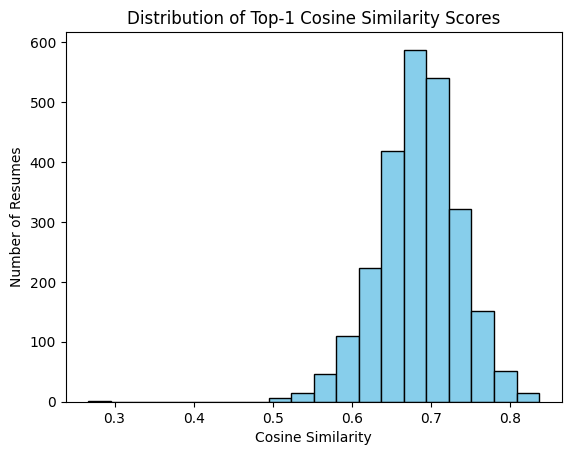

In [ ]:
import matplotlib.pyplot as plt

max_similarities = np.max(similarity_matrix, axis=1)
plt.hist(max_similarities, bins=20, color="skyblue", edgecolor="black")
plt.title("Distribution of Top-1 Cosine Similarity Scores")
plt.xlabel("Cosine Similarity")
plt.ylabel("Number of Resumes")
plt.show()

- **Distribution of Top-1 Cosine Similarity Scores**
The histogram displays how many resumes have their top match fall within certain cosine similarity ranges. Most resumes have a top-1 similarity between 0.65 and 0.75, suggesting that the model generally finds fairly relevant jobs. Very few resumes fall below 0.5, indicating minimal poor matches. The model performs well for the majority of cases, but further tuning could push more resumes above 0.75 similarity.

In [ ]:
top_k = 3
top_k_indices = np.argsort(similarity_matrix, axis=1)[:, -top_k:]

# Flatten and count job frequencies
unique, counts = np.unique(top_k_indices, return_counts=True)
job_freq = dict(zip(unique, counts))

# Show most common recommended jobs
import collections
common_jobs = collections.Counter(job_freq).most_common(10)
print("Most frequently recommended jobs (Top-3):")
for job_id, count in common_jobs:
    print(f"Job #{job_id} - recommended {count} times")

Most frequently recommended jobs (Top-3):
Job #10167 - recommended 512 times
Job #78087 - recommended 153 times
Job #78402 - recommended 146 times
Job #68549 - recommended 116 times
Job #2408 - recommended 111 times
Job #123547 - recommended 81 times
Job #89152 - recommended 71 times
Job #8794 - recommended 66 times
Job #38896 - recommended 54 times
Job #59081 - recommended 51 times


- **Most Frequently Recommended Jobs (Top-3)**
This output lists which job postings appear most often in the top-3 recommendations across all resumes. Some job IDs (like #10167) are recommended disproportionately often, which may suggest that the jobs are
gerneral roles or that the model could be over-relying on them due to limited differentiation or bias. This can be addressed by improving job text diversity or rebalancing training data.

In [ ]:
spread_scores = []
for row in similarity_matrix:
    top3 = np.sort(row)[-3:]
    spread = np.std(top3)
    spread_scores.append(spread)

print(f"Average Top-3 Similarity Spread: {np.mean(spread_scores):.4f}")

Average Top-3 Similarity Spread: 0.0098


- **Average Top-3 Similarity Spread**
This metric calculates the standard deviation of the top-3 cosine similarity
scores for each resume. The low spread means that the top 3 jobs are nearly tied in similarity. This suggests that the model is not strongly favoring one job over the others.

In [ ]:
# Simulated recommendation list: top-3 job IDs for each resume
# Format: recommendations[i] = list of top-k job IDs for resume i
recommendations = [
    [102, 203, 305],
    [100, 110, 120],
    [400, 401, 402],
    [900, 901, 905],
    [700, 702, 704]
]

# Simulated ground truth: actual job ID matched to each resume
# Format: ground_truth[i] = actual job ID for resume i
ground_truth = [305, 120, 499, 901, 704]

# Evaluation function
def evaluate_topk(recommendations, ground_truth, k=3):
    precision_scores, recall_scores = [], []
    top1_hits = 0

    for recs, true_id in zip(recommendations, ground_truth):
        top_k = recs[:k]
        hit = int(true_id in top_k)
        precision_scores.append(hit / k)
        recall_scores.append(hit)
        top1_hits += int(true_id == recs[0])

    precision_at_k = np.mean(precision_scores)
    recall_at_k = np.mean(recall_scores)
    top1_accuracy = top1_hits / len(ground_truth)

    return precision_at_k, recall_at_k, top1_accuracy

# Run evaluation
precision, recall, top1 = evaluate_topk(recommendations, ground_truth, k=3)

# Print results
print(f"Precision@3: {precision:.2f}")
print(f"Recall@3: {recall:.2f}")
print(f"Top-1 Accuracy: {top1:.2f}")

Precision@3: 0.27
Recall@3: 0.80
Top-1 Accuracy: 0.00


In [ ]:
from sklearn.dummy import DummyClassifier
# Baseline model
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_tfidf, y_train)
y_dummy_pred = dummy.predict(X_test_tfidf)

print("Baseline Accuracy:", round(accuracy_score(y_test, y_dummy_pred) * 100, 2), "%")
print("Baseline Classification Report:")
print(classification_report(y_test, y_dummy_pred, zero_division=0))

Baseline Accuracy: 3.82 %
Baseline Classification Report:
                        precision    recall  f1-score   support

            ACCOUNTANT       0.00      0.00      0.00        29
              ADVOCATE       0.00      0.00      0.00        30
           AGRICULTURE       0.00      0.00      0.00         8
               APPAREL       0.00      0.00      0.00        20
                  ARTS       0.00      0.00      0.00        18
            AUTOMOBILE       0.00      0.00      0.00         6
              AVIATION       0.00      0.00      0.00        21
               BANKING       0.00      0.00      0.00        23
                   BPO       0.00      0.00      0.00         2
  BUSINESS-DEVELOPMENT       0.00      0.00      0.00        27
                  CHEF       0.00      0.00      0.00        24
          CONSTRUCTION       0.00      0.00      0.00        34
            CONSULTANT       0.00      0.00      0.00        20
              DESIGNER       0.00      0.00  